In [1]:
%%capture

from cycler import cycler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from palettable.cartocolors.sequential import agSunset_7_r
from palettable.cartocolors.qualitative import Bold_7
import pandas
import scipy.stats
import textwrap
from IPython.display import display, HTML

from data.process import combined, map_filter_na_inplace
from data.process import DISLIKE_DTYPE

CMAP_SEQUENTIAL = agSunset_7_r.mpl_colormap
CMAP_QUALITATIVE = Bold_7.mpl_colormap


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Noto Sans'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['grid.color'] = 'lightgrey'

df = combined()
df['source'] = df.form.apply(
    lambda cell: 'Online' if cell == 'English Online' else 'In Person',
).astype('category')
df.isp.cat.remove_unused_categories(inplace=True)
df.isp_tech.cat.remove_unused_categories(inplace=True)

def annotate_percentages(ax, max):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / max)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2+0.05
        ax.annotate(
            percentage, (x, y),
            fontweight='semibold',
            bbox=dict(boxstyle='round4', fc='w'),
        )

# Report on Community Engagement

_We represent Municipal Broadband PDX, an advocacy campaign supporting digital equity in the Portland metropolitan area. We are not affiliated with CTC Technology and Energy. We have been working with Multnomah County, Portland, Gresham, Troutdale, Fairview, and Wood Village since 2018 to understand the digital needs of our community._

## Background

In December 2019, we convened two town halls to better understand the needs of our community as we consider making large investments in our digital future. Each town hall had this format:

1. An educational segment with presentations and status updates from Multnomah County and our campaign
2. A Q&A segment led by Bob Leek, CIO, Multnomah County
3. A written survey each individual present was asked to fill out
4. A round-table discussion faciliated by a member of our campaign

We held one town hall in Inner Northeast Portland and the other in Gresham. They were approximately two weeks apart. We also asked our Twitter followers who were unable to attend one of our physical town halls to complete the same survey.

_Raw survey response data, as well our methodology for producing the information in this report, is available in our [GitHub repository](https://github.com/municipalbroadband/reports). We always welcome any feedback or further insights._

## Survey Findings

We received a total of 168 survey responses, of which we excluded 6 from our analysis because their data was not usable (for example, no questions answered or answers that were internally inconsistent). We set out to have a rough understanding of the following:

* For our community, do more tangible access problems, like price and customer service, outweigh abstract societal problems like lack of net neutrality?
* How do people feel about funding and governing a municipal ISP?

### Demographics


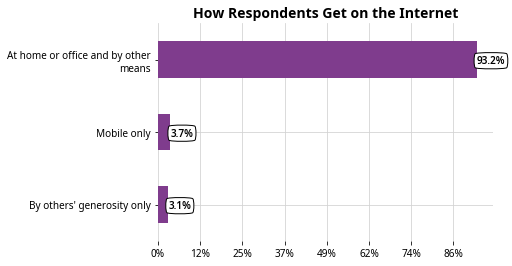

In [2]:
ax = df.filter(['has_internet_premise', 'has_internet_mobile_only', 'has_internet_ext_only']).agg('sum').rename({
    'has_internet_premise': textwrap.fill('At home or office and by other means', 30),
    'has_internet_mobile_only': 'Mobile only',
    'has_internet_ext_only': textwrap.fill("By others' generosity only", 30),
}).plot(
    kind='barh',
    title='How Respondents Get on the Internet',
    cmap=CMAP_QUALITATIVE,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))
ax.invert_yaxis()
annotate_percentages(ax, len(df.index))

plt.show()

Most of our respondents access the internet from home or work. We wondered if many people opted to access the internet only via mobile plans because we're frequently asked whether wired internet access is an outdated idea in this era. We have yet to see practical evidence of this being the case.

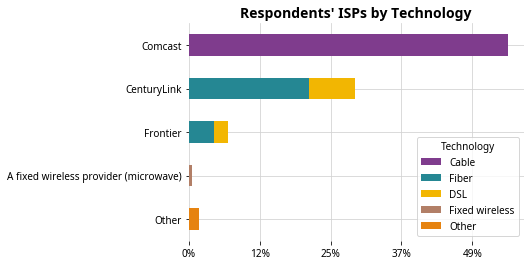

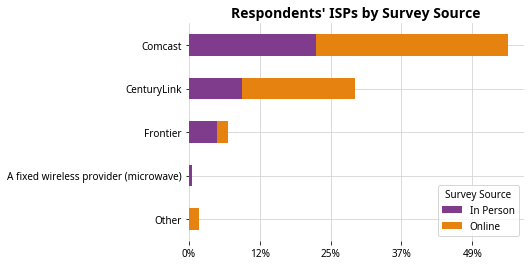

In [3]:
for col, label in {'isp_tech': 'Technology', 'source': 'Survey Source'}.items():
    isps = df.pivot_table(
        index='isp',
        columns=col,
        aggfunc='size',
    )

    ax = isps.plot(kind='barh', stacked=True, cmap=CMAP_QUALITATIVE)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=df.has_internet_premise.count()))
    ax.legend(fancybox=True, title=label)
    ax.set_ylabel(None)
    ax.invert_yaxis()

    plt.title("Respondents' ISPs by {0}".format(label))

    plt.show()

Comcast is the most popular ISP for our respondents. Notice the duopoly between Comcast and the local phone company (either CenturyLink or Frontier, depending on location). Almost none of our respondents use a fixed wireless provider like Stephouse Networks or any other ISP. Looking more closely at the survey data by source, we also surmise that our online survey did not reach many people in eastern Multnomah County where Frontier is available.

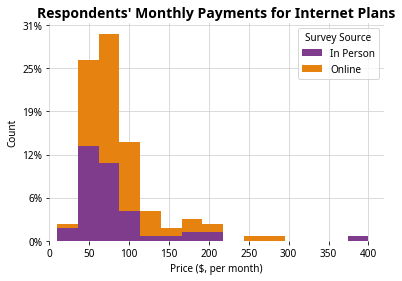

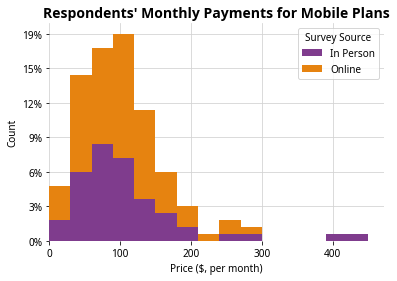

In [4]:
for col, label in {'internet_price': 'Internet', 'mobile_price': 'Mobile'}.items():
    df_pivot = df.filter(['source', col]).pivot(columns='source')
    df_pivot.columns = df_pivot.columns.droplevel()

    ax = df_pivot.plot(kind='hist', stacked=True, bins=15, cmap=CMAP_QUALITATIVE)
    ax.legend(fancybox=True, title='Survey Source')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.title("Respondents' Monthly Payments for {0} Plans".format(label))
    plt.xlabel('Price ($, per month)')
    plt.ylabel('Count')
    plt.xlim(left=0)

    plt.show()

Broadly speaking, our online survey respondents paid more than our in-person respondents for both internet and mobile plans. As noted above, this may be because our online survey biased to the higher-income areas of the metro area. We also guess that our online audience is more technical than the broad swath of the community at our town halls; they may have work requirements or personal reasons to select more expensive plans.

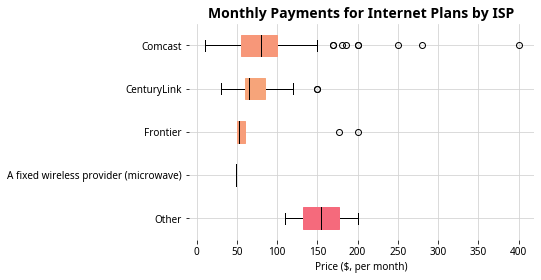

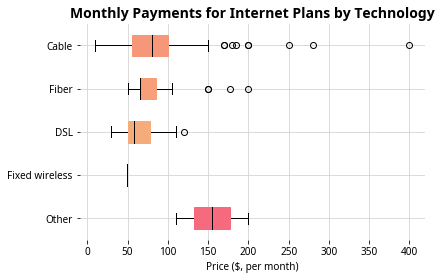

In [5]:
rcmap = cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=df['internet_price'].max(), clip=True),
    cmap=CMAP_SEQUENTIAL,
)

for group, label in {'isp': 'ISP', 'isp_tech': 'Technology'}.items():
    r = df.boxplot(
        by=group,
        column='internet_price',
        vert=False,
        return_type='both',
        patch_artist=True,
    )

    # Color fixes
    mean = df.groupby(group).mean()['internet_price']
    for patch, color in zip(r.internet_price.lines['boxes'], rcmap.to_rgba(mean)):
        patch.set_edgecolor(color)
        patch.set_facecolor(color)

    for k in ['medians', 'whiskers']:
        for line in r.internet_price.lines[k]:
            line.set_color('black')

    r.internet_price.ax.invert_yaxis()

    plt.title('Monthly Payments for Internet Plans by {0}'.format(label))
    plt.suptitle(None)
    plt.xlabel('Price ($, per month)')

    plt.show()

Remember that more than 50% of our respondents use Comcast. These charts give us a clue about price sensitivity: even though comparable fiber connectivity through CenturyLink or Frontier is cheaper on average than Comcast, we don't see people switching to Comcast quickly.

### Municipal Broadband in Society

The second part of our survey provides a qualitative look at how people feel about accessing the internet.

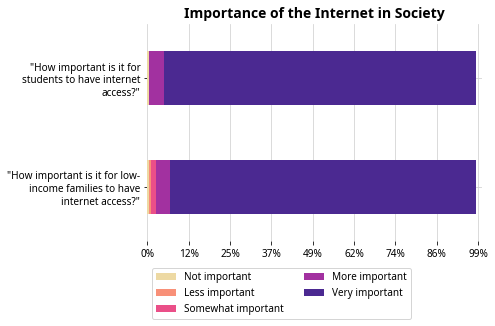

In [6]:
s = df.filter(['importance_student', 'importance_low_income']).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'importance_student': textwrap.fill('"How important is it for students to have internet access?"', 30),
    'importance_low_income': textwrap.fill('"How important is it for low-income families to have internet access?"', 30),
}, inplace=True)

ax = idf.plot(kind='barh', stacked=True, cmap=CMAP_SEQUENTIAL)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Importance of the Internet in Society")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)

plt.show()

Without any consideration for price or how the service would be delivered, almost everyone agreed that it is important for both students and low-income families to have internet access.

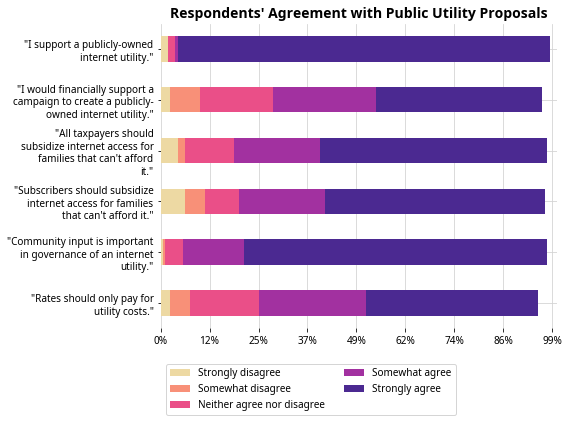

In [7]:
s = df.filter([
    'support_utility',
    'support_financial',
    'importance_user_input',
    'importance_rates_direct',
    'subsidize_subscribers',
    'subsidize_taxpayers',
]).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'support_utility': textwrap.fill('"I support a publicly-owned internet utility."', 30),
    'support_financial': textwrap.fill('"I would financially support a campaign to create a publicly-owned internet utility."', 30),
    'subsidize_taxpayers': textwrap.fill('"All taxpayers should subsidize internet access for families that can\'t afford it."', 30),
    'subsidize_subscribers': textwrap.fill('"Subscribers should subsidize internet access for families that can\'t afford it."', 30),
    'importance_user_input': textwrap.fill('"Community input is important in governance of an internet utility."', 30),
    'importance_rates_direct': textwrap.fill('"Rates should only pay for utility costs."', 30),
}, inplace=True)

ax = idf.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 6),
    cmap=CMAP_SEQUENTIAL,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Respondents' Agreement with Public Utility Proposals")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
plt.tight_layout()

plt.show()

Then we asked a series of questions about funding and oversight of a municipal ISP. We established a baseline by asking each individual whether they supported such an ISP. Unsurprisingly, our respondents almost universally strongly agreed in their support. Then we wanted to understand:

1. **How do we subsidize access for those unable to afford internet access?** We thought there might be a preference for subscribers to the ISP subsidizing access instead of offloading the burden to all taxpayers, but did not find that to be the case. Over 75% of respondents agreed that all taxpayers should subsidize internet access as needed. Some respondents were in fact more emphatic about this, indicating disagreement for subscriber-paid subsidies only.
2. **Should a municipal ISP be able to use its funding for initiatives other than operating the network?** We wondered whether people would accommodate a municipal ISP spending some of its income on, for example, community education or access to new technology in schools, so we asked whether rates should only pay for utility costs. Although we again found about 75% of respondents in agreement with the premise, this question proved more controversial with only about 50% of people strongly agreeing.
3. **Do users want to help run their ISP?** An overwhelming number of respondents, around 90%, agreed that community input is an important aspect of the governance of any internet utility. With FCC rulings about net neutrality and NSA surveillance making news cycles relatively frequently over the past few years, it isn't surprising to see a desire for more transparency and direct democracy in a government-run ISP.

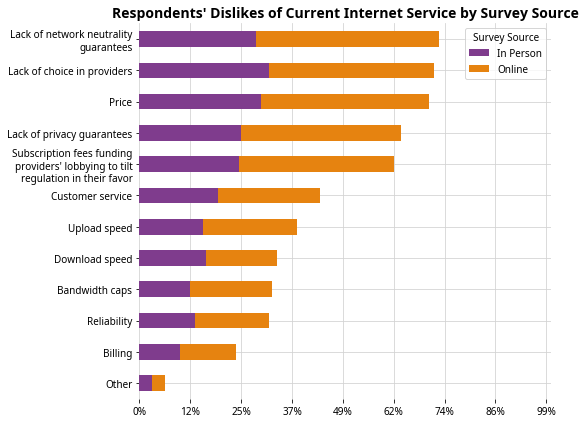

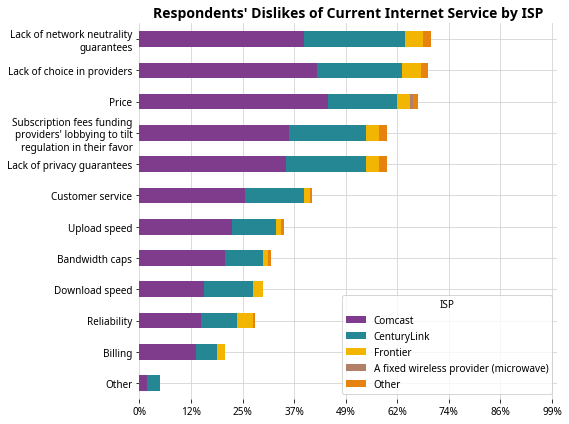

In [8]:
ddf = df.filter(['source', 'isp', 'dislikes']).explode('dislikes')
map_filter_na_inplace(
    lambda s: s.apply(lambda cell: textwrap.fill(cell, 30)),
    ddf, 'dislikes',
)

for group, label in {'source': 'Survey Source', 'isp': 'ISP'}.items():
    s = ddf.groupby([group, 'dislikes']).size()
    ddf_pivot = pandas.DataFrame(s).unstack(level=0)
    ddf_pivot.columns = ddf_pivot.columns.droplevel().astype(str)

    sum_sort = ddf_pivot.sum(axis=1).sort_values().index

    ax = ddf_pivot.loc[sum_sort].plot(
        kind='barh',
        stacked=True,
        figsize=(8, 6),
        cmap=CMAP_QUALITATIVE,
    )
    ax.legend(fancybox=True, title=label)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.title("Respondents' Dislikes of Current Internet Service by {0}".format(label))
    plt.xlim(0, len(df.index))
    plt.ylabel(None)
    plt.tight_layout()

    plt.show()

When we started trying to understand price sensitivity, we quickly reframed our thinking to include what other problems users face when connecting to the internet. We asked users to enumerate their dislikes of their current internet service, allowing them to select many answers. We anticipated more practical dislikes (price, reliability, speed, etc.) because these problems prevent users from effectively using the internet on a day-to-day basis. Of those, only price made it into the top tier of responses. Instead, respondents indicated that societal issues like lack of net neutrality guarantees, lack of choice in providers, excessive lobbying, and lack of privacy guarantees were problematic for them.

Interestly, for Comcast users, price was indeed the most common dislike, outweighing the top two choices for our respondents as a whole.

In [9]:
ddf = df.filter(['internet_price', 'dislikes']).dropna(how='any')
ddf = ddf[lambda df: ((df.internet_price - df.internet_price.mean()) / df.internet_price.std(ddof=0)) < 3]

def dislikes_regression(df, cat):
    dislikes_cat = ddf.dislikes.apply(lambda s: 1 if cat in s else 0)
    regression = scipy.stats.linregress(ddf.internet_price, dislikes_cat)
    return (regression.slope, regression.rvalue ** 2)

display(HTML(pandas.DataFrame({
    cat: dislikes_regression(ddf, cat) for cat in DISLIKE_DTYPE.categories.drop(['Other'])
}).T.rename(columns={0: 'Slope', 1: 'r²'}).to_html()))


,Slope,r²
Price,0.002804,0.055002
Reliability,-0.000443,0.001311
Customer service,0.000906,0.004686
Billing,0.000050,0.000020
Lack of choice in providers,0.001062,0.008826
Download speed,0.000940,0.005697
Upload speed,0.001197,0.008563
Bandwidth caps,0.002319,0.033223
Lack of network neutrality guarantees,0.001467,0.017220
Lack of privacy guarantees,0.001793,0.020261


With that in mind, and considering that Comcast users pay more on average than our other respondents, we anticipated a positive relationship between household internet service costs and disliking price of service. Our data shows a very loose correlation; furthermore, we did not observe any correlation between internet price and any other dislike.

## Round Table Discussions

